<a href="https://colab.research.google.com/github/TakahashiLab/Salmon/blob/main/salmonBehav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#runtime on python3
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [5]:
#runtime on R
library(tidyverse)
# データの読み込み
data <- read_csv("data/My Drive/data/speed_heading_data.csv")

# データ構造の確認
str(data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 6803874 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Condition
dbl (3): Fish, Speed, Heading

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [6,803,874 × 4] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Condition: chr [1:6803874] "controlSea1" "controlSea1" "controlSea1" "controlSea1" ...
 $ Fish     : num [1:6803874] 1 1 1 1 1 1 1 1 1 1 ...
 $ Speed    : num [1:6803874] 3.55 398.37 285.13 294.37 258.28 ...
 $ Heading  : num [1:6803874] 12.4 12.9 -137.2 -146.1 -156.1 ...
 - attr(*, "spec")=
  .. cols(
  ..   Condition = col_character(),
  ..   Fish = col_double(),
  ..   Speed = col_double(),
  ..   Heading = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [6]:
# circularパッケージのインストール
install.packages("circular")
# multcompパッケージのインストール
install.packages("multcomp")

# パッケージのロード
library(circular)
library(multcomp)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
perform_anova_and_posthoc <- function(data, control_label, condition_group, group_label) {
  # Combine control data with experimental data for ANOVA
  anova_data <- data.frame()
  anova_conditions <- c()
  anova_groups <- c()
  anova_fish <- c()

  # Filter out specified control and condition data
  control_data <- data[data$Condition == control_label, ]
  for (i in 1:length(condition_group)) {
    condition <- condition_group[i]
    condition_data <- data[data$Condition == condition, ]

    # Combine control and condition data
    combined_data <- rbind(control_data, condition_data)
    combined_conditions <- c(rep(control_label, nrow(control_data)), rep(condition, nrow(condition_data)))
    combined_groups <- rep(group_label, nrow(combined_data))
    combined_fish <- c(control_data$Fish, condition_data$Fish)

    # Append to ANOVA data
    anova_data <- rbind(anova_data, combined_data)
    anova_conditions <- c(anova_conditions, combined_conditions)
    anova_groups <- c(anova_groups, combined_groups)
    anova_fish <- c(anova_fish, combined_fish)
  }

  # Convert data for ANOVA
  anova_table <- data.frame(
    Condition = anova_conditions,
    Group = anova_groups,
    Fish = anova_fish,
    Speed = anova_data$Speed,
    Distance_10s = anova_data$Distance_10s
  )

  # Perform one-way ANOVA
  anova_results <- aov(Speed + Distance_10s ~ Condition, data = anova_table)

  # Display results
  cat("***---***\n")
  cat("Results for", group_label, "conditions:\n")
  print(summary(anova_results))

  # Determine which variables are significantly different
  summary_results <- summary(anova_results)
  significant_vars <- which(summary_results[[1]]$`Pr(>F)` < 0.05)
  sig_measure_names <- c("Speed", "Distance_10s")
  if (length(significant_vars) > 0) {
    cat("Significant differences found in:\n")
    for (i in significant_vars) {
      cat(sig_measure_names[i], "\n")
    }
  } else {
    cat("No significant differences found.\n")
  }

  # Perform post-hoc tests if significant
  if (any(!is.na(summary_results[[1]]$`Pr(>F)`) & summary_results[[1]]$`Pr(>F)` < 0.05)) {
    posthoc_results <- TukeyHSD(anova_results)
    sig_posthoc <- posthoc_results$Condition[posthoc_results$Condition[, "p adj"] < 0.05, ]
    if (nrow(sig_posthoc) > 0) {
      cat("Significant post-hoc comparisons:\n")
      for (i in 1:nrow(sig_posthoc)) {
        cat(row.names(sig_posthoc)[i], ": p-value =", sig_posthoc[i, "p adj"], "\n")
      }
    } else {
      cat("No significant post-hoc comparisons found.\n")
    }
  }

  # Perform Watson-Williams test for Heading
  heading_data <- anova_data$Heading
  heading_data <- conversion.circular(circular(heading_data, units = "degrees"), units = "radians")
  heading_conditions <- factor(anova_conditions)

  # Display heading data for checking
  #cat("Heading data (radians) to be analyzed using Watson-Williams test:\n")
  #print(data.frame(Condition = anova_conditions, Heading = heading_data))

  # Perform pairwise Watson-Williams tests for heading
  significant_pairs <- c()
  p_values <- list()
  unique_conditions <- unique(heading_conditions)
  num_comparisons <- 0

  for (i in 1:length(unique_conditions)) {
    for (j in (i + 1):length(unique_conditions)) {
      cond1 <- unique_conditions[i]
      cond2 <- unique_conditions[j]
      data1 <- heading_data[heading_conditions == cond1]
      data2 <- heading_data[heading_conditions == cond2]

      if (length(data1) > 0 && length(data2) > 0) {
        p_pairwise <- try(circular::watson.two.test(data1, data2), silent = TRUE)
        num_comparisons <- num_comparisons + 1
        if (inherits(p_pairwise, "try-error")) {
          cat("Error in Watson-Williams test between", cond1, "and", cond2, "\n")
          next
        }
        if (!is.null(p_pairwise$p.value) && length(p_pairwise$p.value) > 0) {
          p_values[[paste(cond1, "vs", cond2)]] <- p_pairwise$p.value
          if (p_pairwise$p.value < 0.05 / num_comparisons) { # Bonferroni correction
            significant_pairs <- c(significant_pairs, paste(cond1, "vs", cond2, ": p-value =", p_pairwise$p.value))
          }
        }
      }
    }
  }

  # Display results for Heading
  if (length(significant_pairs) > 0) {
    cat("Significant differences found in Heading between conditions:\n")
    for (pair in significant_pairs) {
      cat(pair, "\n")
    }
  } else {
    cat("No significant differences found in Heading between conditions.\n")
  }

  # Display p-values for each condition pair
  cat("P-values for each condition pair in Heading (before Bonferroni correction):\n")
  for (pair in names(p_values)) {
    cat(pair, ": p-value =", p_values[[pair]], "\n")
  }
}

calculateMomentaryActivityIndex <- function(speed) {
  # Calculate the standard deviation of speed and heading variance for each fish
  speed_std <- sd(speed)  # Standard deviation across time points for each fish

  # Define the threshold as 3 times the standard deviation
  speed_threshold <- 3 * speed_std

  # Calculate the activity index as a binary indicator if speed is above the threshold
  is_active_speed <- speed > speed_threshold

  # Combine both conditions for activity index (either condition being true)
  activity_index <- sum(is_active_speed) / length(speed)

  return(activity_index)
}


In [8]:
# Define constants
fps <- 30
time_limit <- 20 * 60 * fps # 20 minutes in frames
one_minute_frames <- 60 * fps

# Get unique conditions and fish IDs
conditions <- unique(data$Condition)
fish_ids <- unique(data$Fish)

# Initialize arrays to store averaged data
averaged_data <- data.frame()

# Loop through each condition and fish to filter and calculate mean values
for (i in 1:length(conditions)) {
  for (j in 1:length(fish_ids)) {
    # Filter data for the current condition and fish
    condition_fish_data <- data[data$Condition == conditions[i] & data$Fish == fish_ids[j], ]

    # Apply the time limit to speed and heading data
    if (nrow(condition_fish_data) > time_limit) {
      condition_fish_data <- condition_fish_data[(time_limit + 1):nrow(condition_fish_data), ]
    } else {
      next
    }

    # Calculate speed standard deviation and threshold
    speed_std <- sd(condition_fish_data$Speed)
    speed_var <- var(condition_fish_data$Speed)
    speed_threshold <- 3 * speed_std

    # Filter data where speed is below the threshold for heading calculation
    filtered_heading_data <- condition_fish_data[condition_fish_data$Speed <= speed_threshold, ]

    if (nrow(filtered_heading_data) == 0) {
      next
    }

    # Calculate mean heading for filtered data
    mean_heading <- circular::mean.circular(circular::circular(filtered_heading_data$Heading, units = "degrees", template = "geographics"))
    mean_heading_revolutions <- mean(cumsum(c(0, diff(filtered_heading_data$Heading))))

    # Calculate other mean values for unfiltered data
    mean_speed <- mean(condition_fish_data$Speed)
    mean_acceleration <- mean(c(0, diff(condition_fish_data$Speed)))
    mean_activity_frequency <- calculateMomentaryActivityIndex(condition_fish_data$Speed)

    # Calculate average distance moved every 10 seconds
    ten_seconds_frames <- 10 * fps
    distances <- c()
    for (start in seq(1, nrow(condition_fish_data), by = ten_seconds_frames)) {
      end <- min(start + ten_seconds_frames - 1, nrow(condition_fish_data))
      distance <- sum(condition_fish_data$Speed[start:end]) / fps
      distances <- c(distances, distance)
    }
    mean_distance_10s <- mean(distances)

    # Calculate mean speed per minute
    minute_means <- c()
    for (start in seq(1, nrow(condition_fish_data), by = one_minute_frames)) {
      end <- min(start + one_minute_frames - 1, nrow(condition_fish_data))
      minute_mean <- mean(condition_fish_data$Speed[start:end])
      minute_means <- c(minute_means, minute_mean)
    }
    mean_speed_per_minute <- mean(minute_means)

    mean_values <- data.frame(
      Speed = mean_speed,
      Acceleration = mean_acceleration,
      ActivityFrequency = mean_activity_frequency,
      Heading = mean_heading,
      HeadingRevolutions = mean_heading_revolutions,
      Distance_10s = mean_distance_10s,
      SpeedVariance = speed_var,
      MeanSpeedPerMinute = mean_speed_per_minute,
      Fish = fish_ids[j],
      Condition = conditions[i]
    )

    # Append the mean values to the averaged data table
    averaged_data <- rbind(averaged_data, mean_values)
  }
}

# Define control conditions for different types of conditions
control_sea <- "controlSea2"
control_rot <- "controlRot1"
control_t1 <- "controlT1"

# Separate data into different experimental groups, excluding specified controls
sea_conditions <- setdiff(conditions[grep("Sea", conditions)], control_sea)
rot_conditions <- setdiff(conditions[grep("rotation|controlRot2", conditions)], control_rot)
microt_conditions <- setdiff(conditions[grep("microT|controlT", conditions)], control_t1)

# Perform ANOVA and post-hoc tests for Sea conditions
group_label <- "sea"
perform_anova_and_posthoc(averaged_data, control_sea, sea_conditions, group_label)

# Perform ANOVA and post-hoc tests for Rot conditions
group_label <- "rotation"
perform_anova_and_posthoc(averaged_data, control_rot, rot_conditions, group_label)

# Perform ANOVA and post-hoc tests for microT conditions
group_label <- "microT"
perform_anova_and_posthoc(averaged_data, control_t1, microt_conditions, group_label)


***---***
Results for sea conditions:
            Df Sum Sq Mean Sq F value  Pr(>F)   
Condition    3 131772   43924   5.979 0.00145 **
Residuals   50 367347    7347                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Significant differences found in:
Speed 
Significant post-hoc comparisons:
okhotskSea-beringSea : p-value = 0.01089548 
okhotskSea-controlSea2 : p-value = 0.006219874 


Warning message in circular::watson.two.test(data1, data2):
“'y': No observations (at least after removing missing values)”


No significant differences found in Heading between conditions.
P-values for each condition pair in Heading (before Bonferroni correction):
***---***
Results for rotation conditions:
            Df  Sum Sq Mean Sq F value  Pr(>F)   
Condition    4  855616  213904   4.445 0.00302 **
Residuals   67 3224473   48126                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Significant differences found in:
Speed 
Significant post-hoc comparisons:
controlRot2-controlRot1 : p-value = 0.04063424 
rotation270-controlRot1 : p-value = 0.02391468 


Warning message in circular::watson.two.test(data1, data2):
“'y': No observations (at least after removing missing values)”


No significant differences found in Heading between conditions.
P-values for each condition pair in Heading (before Bonferroni correction):
***---***
Results for microT conditions:
            Df Sum Sq Mean Sq F value Pr(>F)
Condition    4    994   248.6   0.473  0.755
Residuals   67  35223   525.7               
No significant differences found.


Warning message in circular::watson.two.test(data1, data2):
“'y': No observations (at least after removing missing values)”


No significant differences found in Heading between conditions.
P-values for each condition pair in Heading (before Bonferroni correction):


In [13]:
install.packages("multcompView")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Significant Category Pairs:
                    diff      lwr      upr       p adj
Rotation-microT 7.002037 1.255803 12.74827 0.012539161
Sea-microT      9.984638 3.889837 16.07944 0.000482309

ANOVA Summary for Categories:
             Df Sum Sq Mean Sq F value   Pr(>F)    
Category      2   2184    1092   8.273 0.000426 ***
Residuals   123  16236     132                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


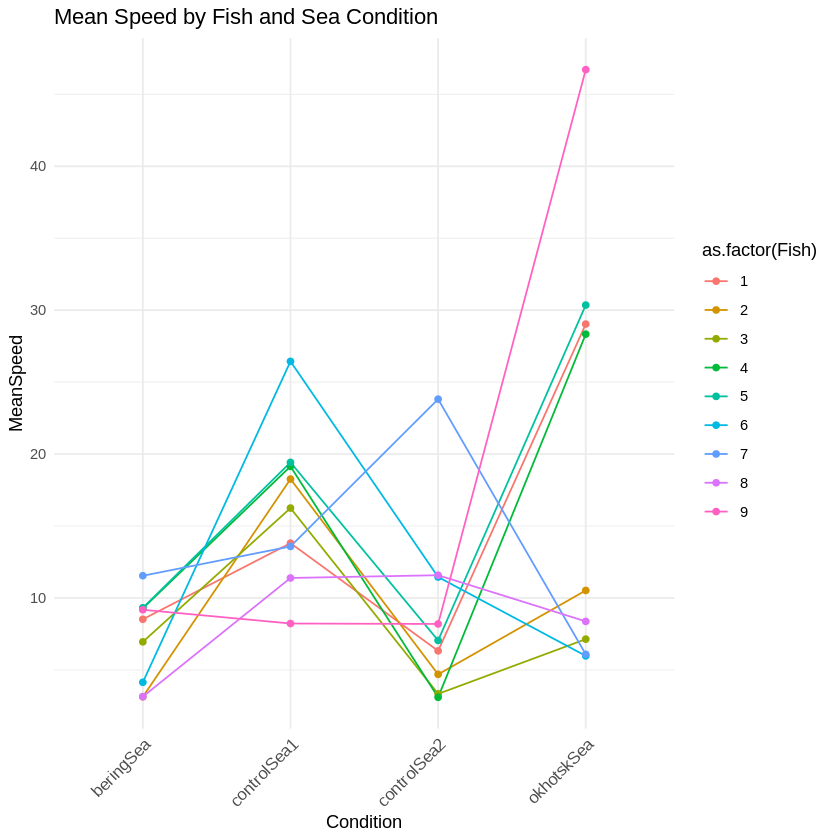

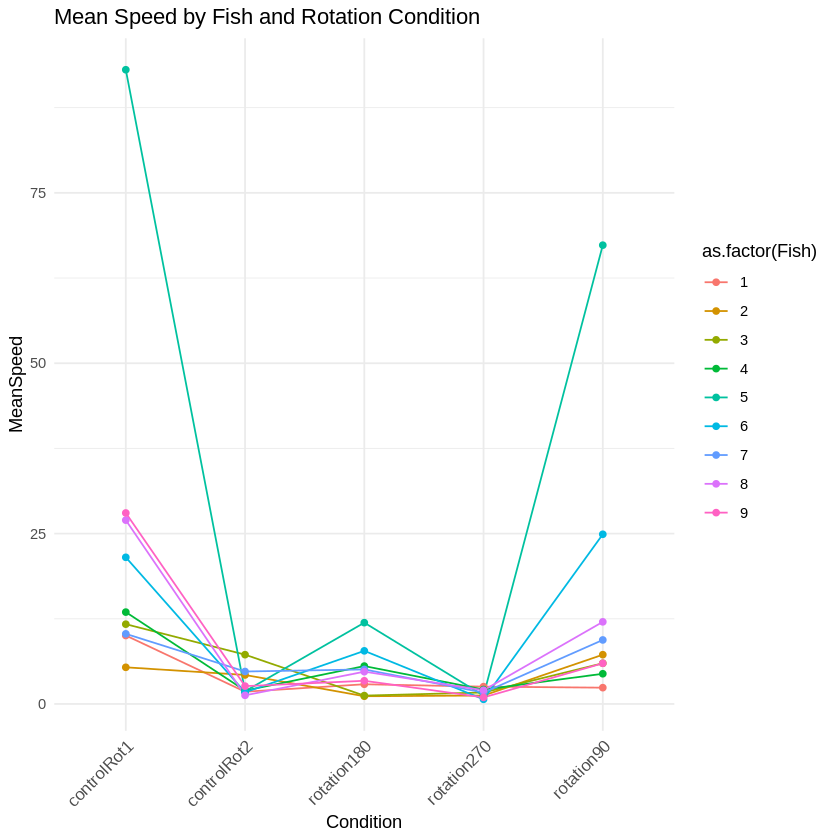

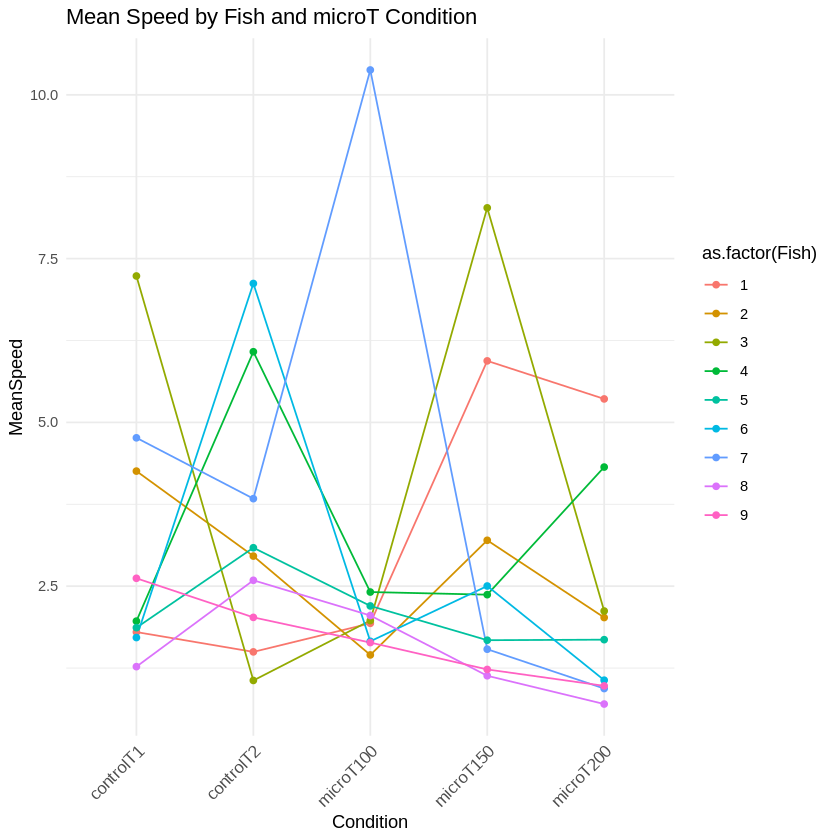

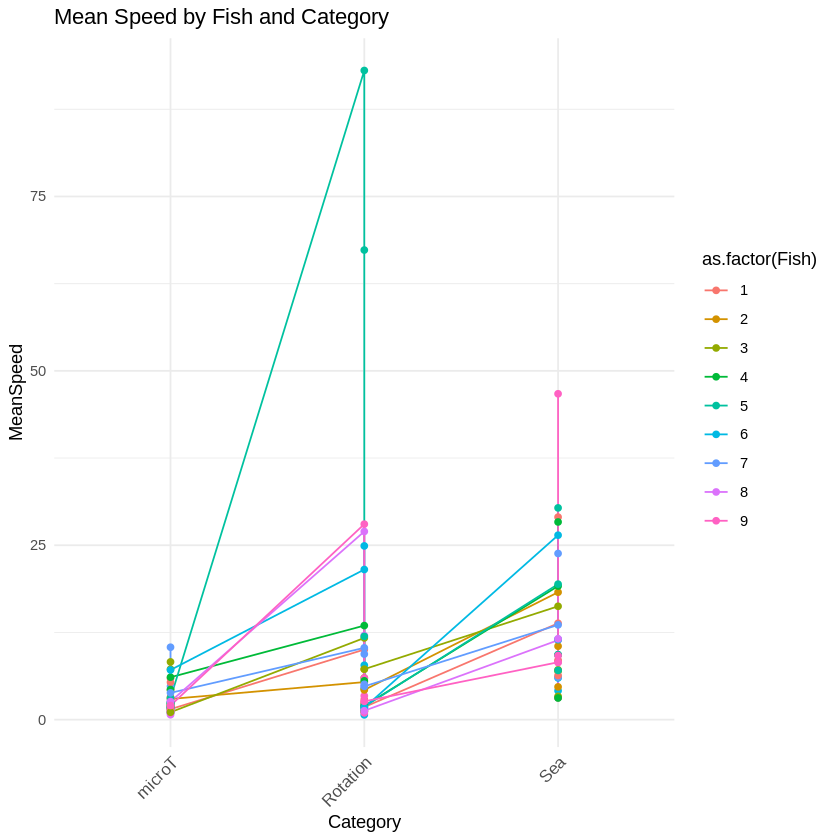

In [30]:
# 必要なパッケージのインストールとロード
if (!require(circular)) install.packages("circular")
if (!require(multcomp)) install.packages("multcomp")
if (!require(tidyverse)) install.packages("tidyverse")

library(circular)
library(multcomp)
library(tidyverse)

# データの読み込み
#data <- read_csv("data/My Drive/data/speed_heading_data.csv")

# データの前処理
data$Heading <- circular(data$Heading, units="degrees", template="none")

# 定数の定義
fps <- 30
time_limit <- 20 * 60 * fps # 20分をフレーム数に変換
one_minute_frames <- 60 * fps

# 各条件ごとにfish毎の平均値を計算し、20分の時間制限を適用
averaged_data <- data.frame()

conditions <- unique(data$Condition)
fish_ids <- unique(data$Fish)

for (i in 1:length(conditions)) {
  for (j in 1:length(fish_ids)) {
    # 現在の条件と魚のデータをフィルタリング
    condition_fish_data <- data[data$Condition == conditions[i] & data$Fish == fish_ids[j], ]

    # 20分の時間制限を適用
    if (nrow(condition_fish_data) > time_limit) {
      condition_fish_data <- condition_fish_data[(time_limit + 1):nrow(condition_fish_data), ]
    } else {
      next
    }

    # データが存在しない場合は次のループへ
    if (nrow(condition_fish_data) == 0) {
      next
    }

    # 平均値の計算
    mean_speed <- mean(condition_fish_data$Speed, na.rm = TRUE)
    mean_heading <- mean.circular(circular(condition_fish_data$Heading, units = "degrees", template = "geographics"))

    mean_values <- data.frame(
      MeanSpeed = mean_speed,
      MeanHeading = mean_heading,
      Fish = fish_ids[j],
      Condition = conditions[i]
    )

    # 平均値を追加
    averaged_data <- rbind(averaged_data, mean_values)
  }
}

# 条件を海、回転、microTの3つに分類
control_sea <- "controlSea2"
control_rot <- "controlRot1"
control_t1 <- "controlT1"

#sea_conditions <- setdiff(conditions[grep("Sea", conditions)], control_sea)
#rot_conditions <- setdiff(conditions[grep("rotation|controlRot2", conditions)], control_rot)
#microt_conditions <- setdiff(conditions[grep("microT|controlT", conditions)], control_t1)

sea_conditions <- conditions[grep("Sea", conditions)]
rot_conditions <- conditions[grep("rotation|controlRot", conditions)]
microt_conditions <- conditions[grep("microT|controlT", conditions)]

# カテゴリーの追加
averaged_data <- averaged_data %>%
  mutate(Category = case_when(
    Condition %in% sea_conditions ~ "Sea",
    Condition %in% rot_conditions ~ "Rotation",
    Condition %in% microt_conditions ~ "microT",
    TRUE ~ "Other"
  ))

# カテゴリー間のANOVAと事後検定
anova_category <- aov(MeanSpeed ~ Category, data = averaged_data)
summary_category <- summary(anova_category)
tukey_category <- TukeyHSD(anova_category)
significant_category <- as.data.frame(tukey_category$Category) %>% filter(`p adj` < 0.05)

# 有意なカテゴリー間ペアを表示
cat("Significant Category Pairs:\n")
print(significant_category)

# ANOVAの詳細結果を表示
cat("\nANOVA Summary for Categories:\n")
print(summary_category)

# 条件ごとのfish毎の平均値のプロット作成
plot_fish_means <- function(data, y, title) {
  ggplot(data, aes(x = Condition, y = get(y), color = as.factor(Fish), group = Fish)) +
    geom_line() +
    geom_point() +
    labs(title = title, y = y) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) # x軸の調整
}

# プロットを表示
plot_speed_sea <- plot_fish_means(averaged_data %>% filter(Condition %in% sea_conditions), "MeanSpeed", "Mean Speed by Fish and Sea Condition")
plot_speed_rot <- plot_fish_means(averaged_data %>% filter(Condition %in% rot_conditions), "MeanSpeed", "Mean Speed by Fish and Rotation Condition")
plot_speed_microt <- plot_fish_means(averaged_data %>% filter(Condition %in% microt_conditions), "MeanSpeed", "Mean Speed by Fish and microT Condition")

print(plot_speed_sea)
print(plot_speed_rot)
print(plot_speed_microt)

# カテゴリーごとの平均値のプロット作成
plot_category_means <- function(data, y, title) {
  ggplot(data, aes(x = Category, y = get(y), color = as.factor(Fish), group = Fish)) +
    geom_line() +
    geom_point() +
    labs(title = title, y = y) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) # x軸の調整
}

# プロットを表示
plot_speed_category <- plot_category_means(averaged_data, "MeanSpeed", "Mean Speed by Fish and Category")

print(plot_speed_category)
